In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-16 00:07:55.868463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 00:07:57.701466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-16 00:07:57.701699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = 'master-thesis/data-analysis/'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [15]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [16]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [17]:
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [18]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [19]:
num_bots = 0 # bots iter.
num_humans = 0 # humans iter.

for index, record in users_df1.iterrows():
    if record['label']=='bot':
      num_bots += 1
    if record['label']=='human':
      num_humans += 1

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  7867
Number of bots:  2133


In [20]:
org_users_df = users_df1.copy()
users_df2 = org_users_df.copy()

In [21]:
users_df = pd.DataFrame()

i = 0 # bots iter.
j = 0 # humans iter.
k = 0
max_bots = num_bots
max_humans = num_bots
for index, record in users_df2.iterrows():
  if k < (max_bots+max_humans):
    if record['label']=='bot' and i < max_bots:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      i += 1
      k += 1
    if record['label']=='human' and j < max_humans:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      j += 1
      k += 1

## Data preparation

In [22]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [23]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

### Encoding of non-numeric information which will be used by model

In [24]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [25]:
users_df

,id,label,username,name,created_at,verified,protected,withheld,has_location,location,has_profile_image_url,has_pinned_tweet,url,followers_count,following_count,tweet_count,listed_count,has_description,description,descr_no_hashtags,descr_no_cashtags,descr_no_mentions,descr_no_urls,url_no_urls
0,1484544053572419585,0,blessing_xettry,#Blessing xettry,1.642778e+09,0,0,0,1,Nepal,1,0,,0.0,24.0,1.0,0.0,1,"Okay, well, maybe not forever. But at least until you make some changes.",0.0,0.0,0.0,0.0,0.0
1,1447956502443069446,0,menametaken,winwinnie,1.634055e+09,0,0,0,1,your walls,1,0,,0.0,20.0,1.0,0.0,1,20 | uni student | life goes brrr \nyes I do and it's called art\n#thickthighssavelifes,1.0,0.0,0.0,0.0,0.0
2,1487790036322033674,0,VShipExpress1,V Ship Express,1.643552e+09,0,0,0,1,Canada,1,0,https://t.co/HE80bmcMvk,0.0,0.0,26.0,0.0,1,"VShip Express is a one-stop shop for all your logistics needs be it a local parcel or international cargo sent through air, ship, or land.",0.0,0.0,0.0,0.0,1.0
3,901531094507507715,0,dbamiloye,Damilola Mike-Bamiloye,1.503777e+09,0,0,0,1,Nigeria,1,1,,54528.0,190.0,5039.0,11.0,1,"A gospel film writer, producer, director and actor working in Mount Zion films production.",0.0,0.0,0.0,0.0,0.0
4,1329634133379665921,0,Languagegamesny,Languagegamesnyc,1.605844e+09,0,0,0,1,New York,1,1,https://t.co/jN9HYPLgeV,1.0,128.0,79.0,0.0,1,Trying to catch my white whale TikTok languagegames instagram Languagegamesnyc,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,1214029823984599040,1,againstempiric1,magee ��,1.578282e+09,0,0,0,0,None,1,0,,172.0,81.0,2245.0,5.0,1,27 ����: ASX Trader/Investor. Ex Software Engineer. Logic. Armchair Economist.,0.0,0.0,0.0,0.0,0.0
9978,1480060548410580995,1,MetawarOfficial,Metawar,1.641709e+09,0,0,0,0,None,1,1,,283820.0,2.0,7.0,54.0,1,Telegram Group: https://t.co/Qdo4oYS9VV\nWebsite: https://t.co/QJGho2voTh,0.0,0.0,0.0,2.0,0.0
9979,1338724314766585856,1,steinartgroup,stein art group,1.608012e+09,0,0,0,0,None,1,0,https://t.co/WbtX3bST1a,174.0,1555.0,34.0,0.0,1,"2mm Flexible Sandstone, Concrete, Marble and Terrazzo for Interior and Exterior Walls.",0.0,0.0,0.0,0.0,1.0
9987,782641505089363968,1,kessentiniglp,Marouane Kessentini,1.475431e+09,0,0,0,0,None,1,0,,183.0,187.0,159.0,0.0,0,,0.0,0.0,0.0,0.0,0.0


#### Null and NaN statistics

In [26]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
withheld: 0
has_location: 0
location: 1413
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


### Filter data, left column by feature importance based on SHAP results

In [27]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'followers_count', 'tweet_count', 'following_count'])
users_reduced_df

,label,followers_count,tweet_count,following_count
0,0,0.0,1.0,24.0
1,0,0.0,1.0,20.0
2,0,0.0,26.0,0.0
3,0,54528.0,5039.0,190.0
4,0,1.0,79.0,128.0
...,...,...,...,...
9977,1,172.0,2245.0,81.0
9978,1,283820.0,7.0,2.0
9979,1,174.0,34.0,1555.0
9987,1,183.0,159.0,187.0


### Data type conversion (to float)

In [28]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [29]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

# Data analysis

In [30]:
sns.set(font_scale=4)

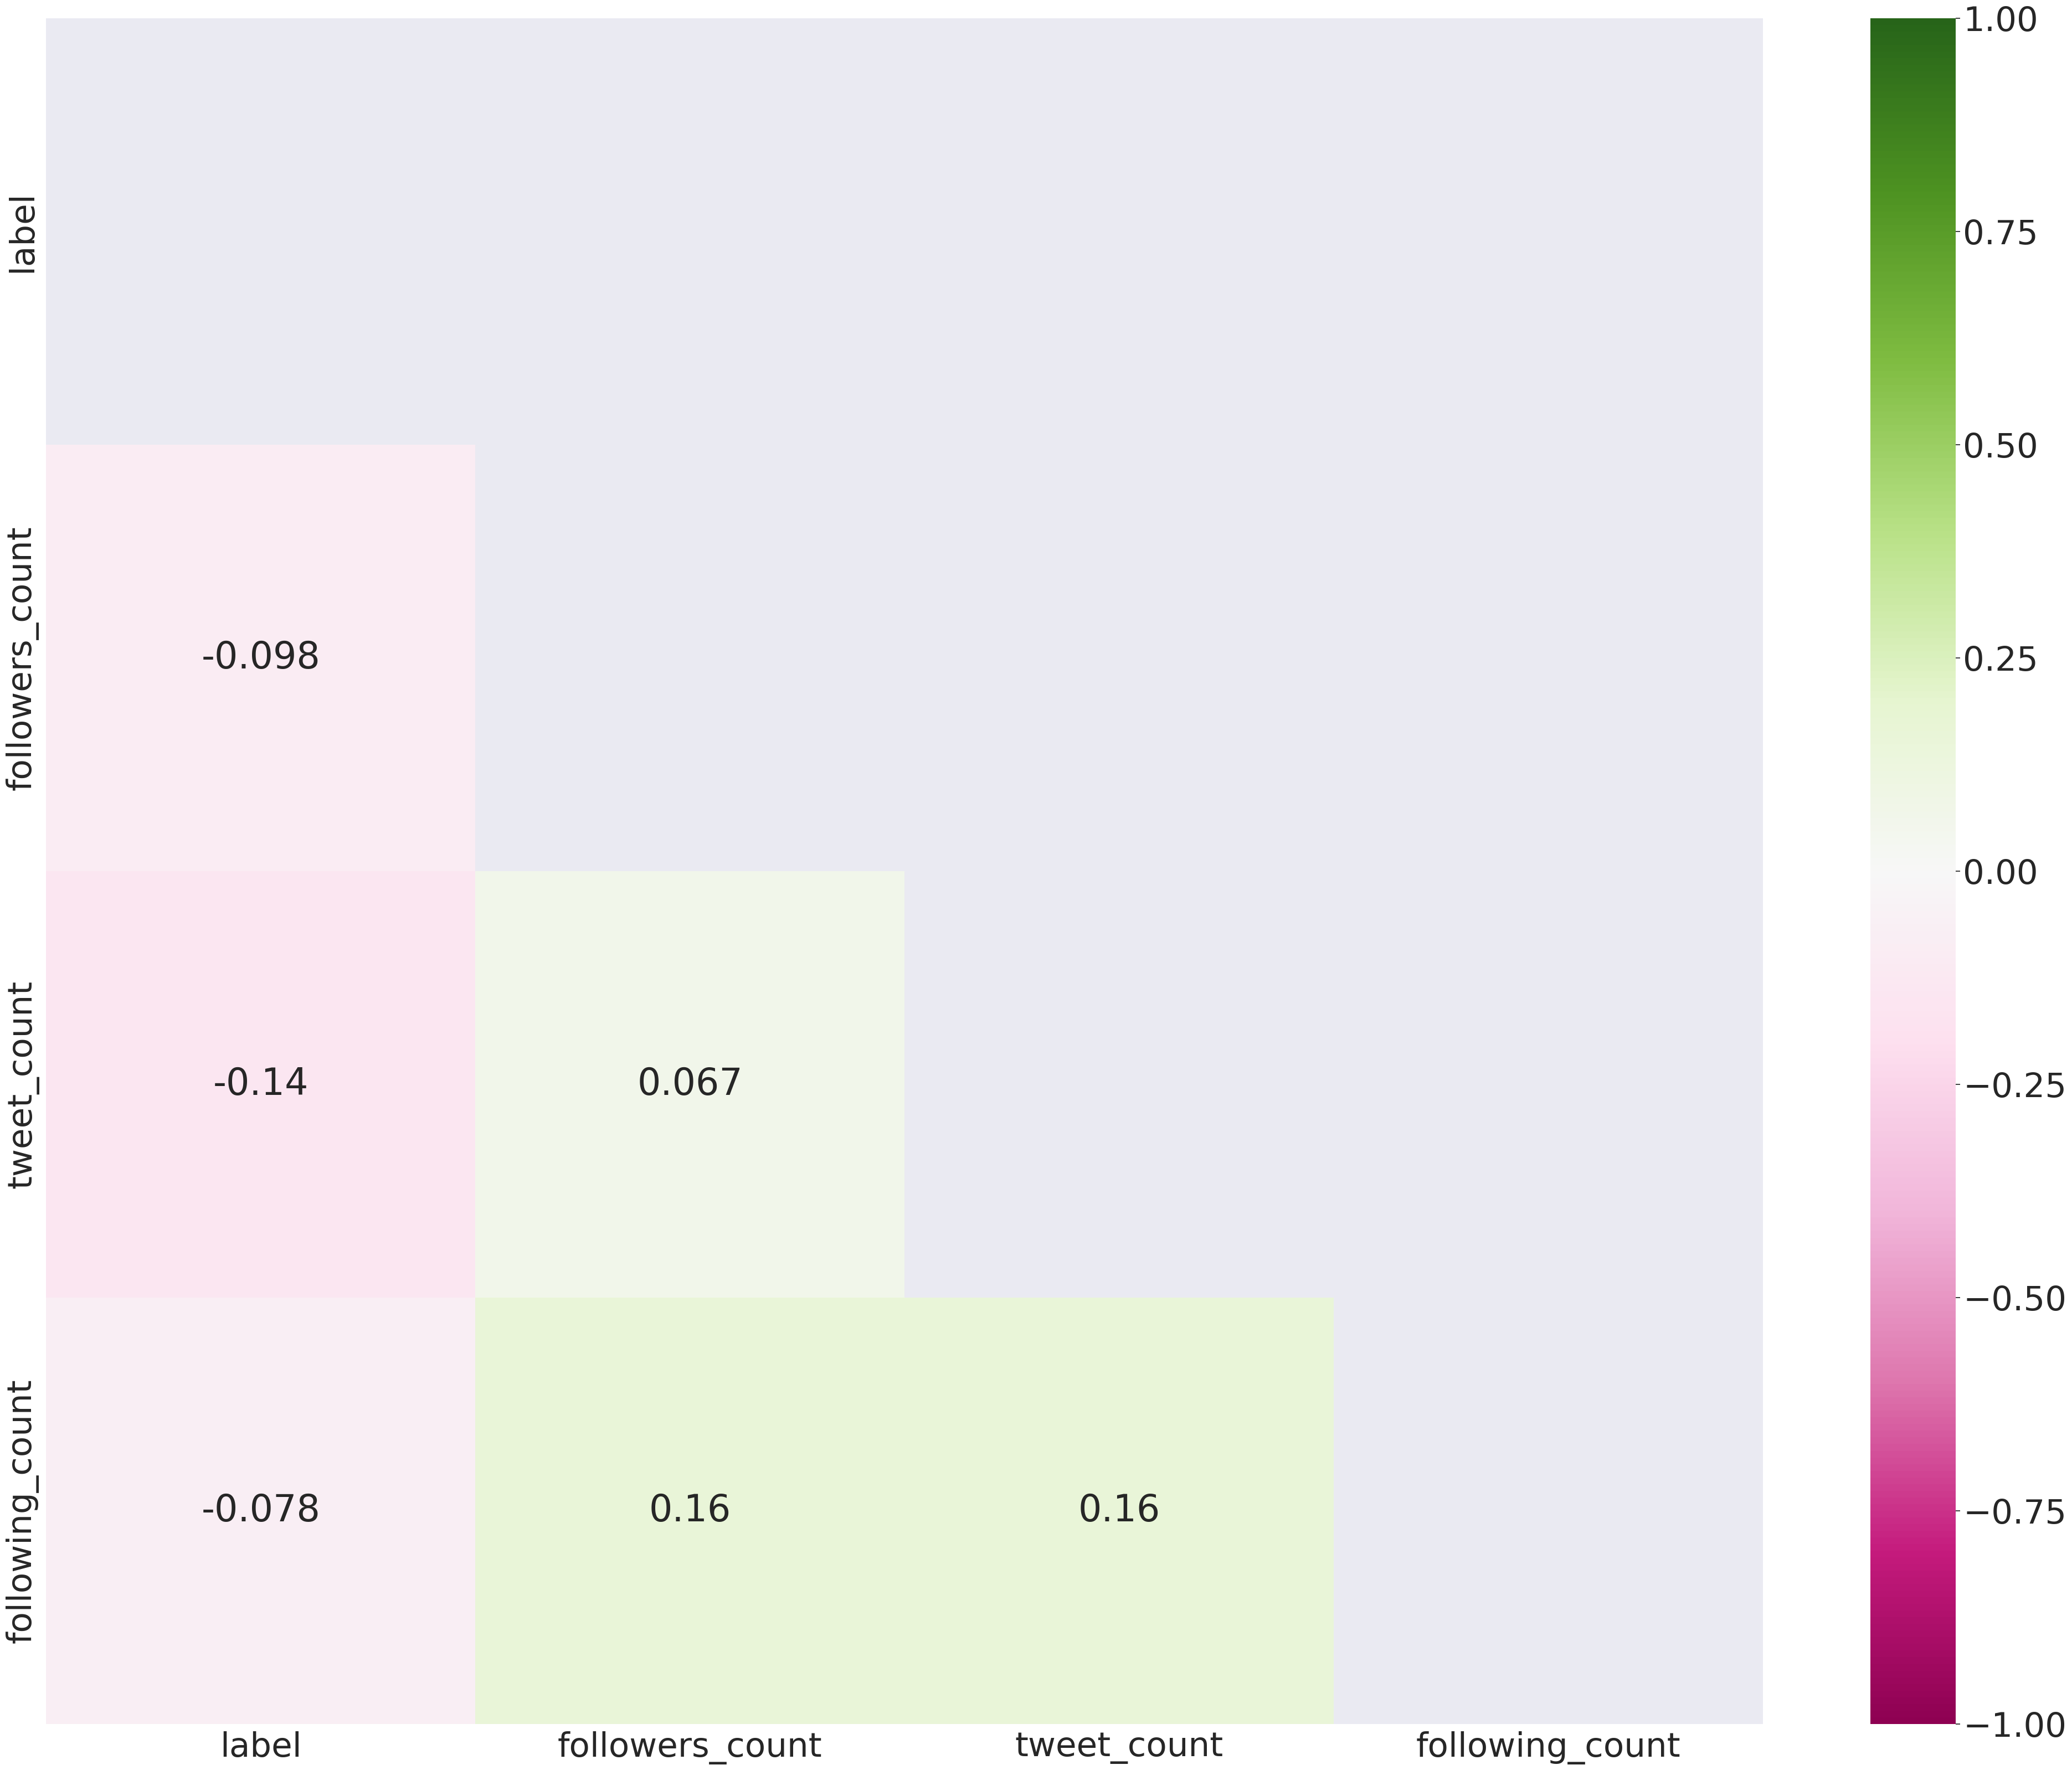

In [31]:
corr_threshold = 0.5
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [32]:
sns.set(font_scale=1)

In [33]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

#### Split data for input and output

In [73]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [74]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [75]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [76]:
def create_confusion_matrix(test_Y, out_Y):
  cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure()
  fig = plt.figure(figsize=(7,7))
  ax = fig.add_subplot(111)

  sns.heatmap(
      cm,
      annot=labels,
      annot_kws={"size": 16},
      fmt='',
      cmap=plt.cm.Blues,
      cbar=False
  )
  ax.set_title("Confusion matrix", fontsize=20)
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
  ax.set_ylabel('True', fontsize=16)
  ax.set_xlabel('Predicted', fontsize=16)

  fig.show()

## Neural network models 

In [77]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')
# PlotLosses
plot_losses = PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [78]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses,
                           early_stop,
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [40]:
def create_model_1(shape):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

In [41]:
model_name = 'model_users_only_1000_1_v2'
shape = (train_X.shape[1],)
model = create_model_1(shape=shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 6

2023-08-16 00:09:07.856736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-16 00:09:07.856792: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-16 00:09:07.856831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f8fbce7ccb17): /proc/driver/nvidia/version does not exist
2023-08-16 00:09:07.857243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### Train model

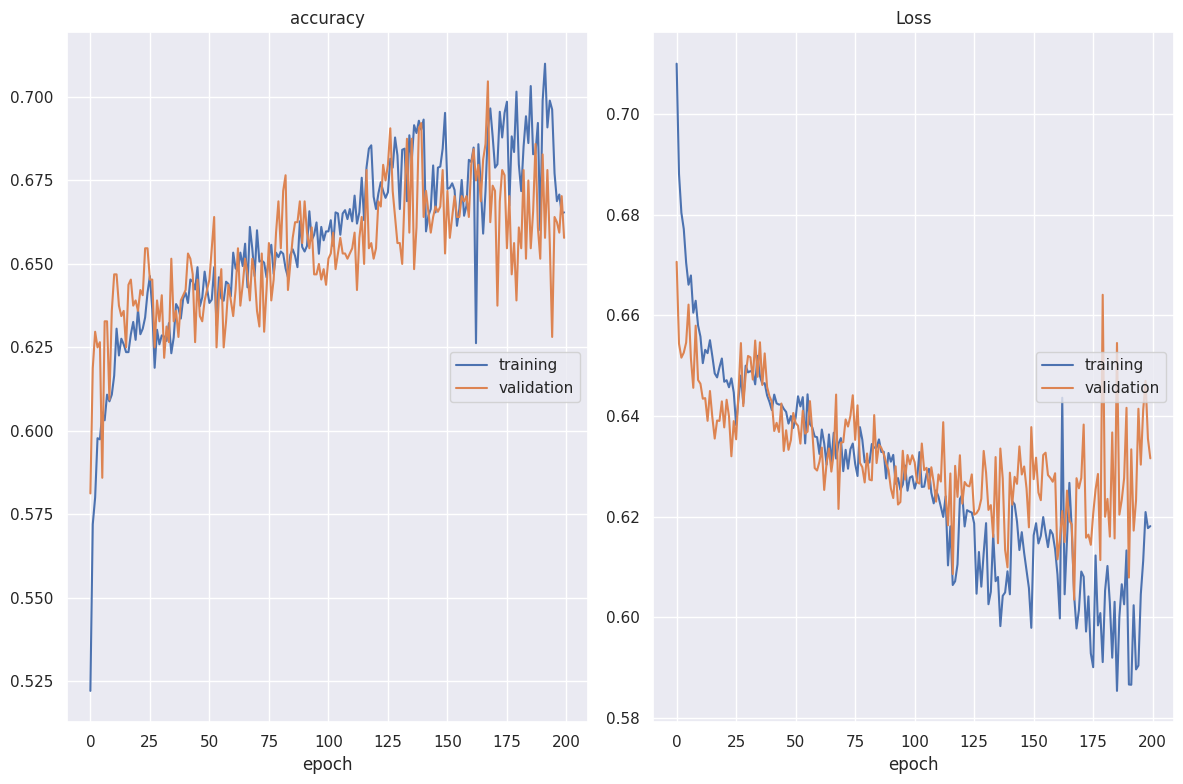

accuracy
	training         	 (min:    0.522, max:    0.710, cur:    0.665)
	validation       	 (min:    0.581, max:    0.705, cur:    0.658)
Loss
	training         	 (min:    0.585, max:    0.710, cur:    0.618)
	validation       	 (min:    0.603, max:    0.671, cur:    0.632)

Epoch 200: val_accuracy did not improve from 0.70469
60/60 [==============================] - 1s 13ms/step - loss: 0.6181 - accuracy: 0.6654 - val_loss: 0.6316 - val_accuracy: 0.6578


In [42]:
model = train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [43]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

### Prediction

In [47]:
out_Y_org = model.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

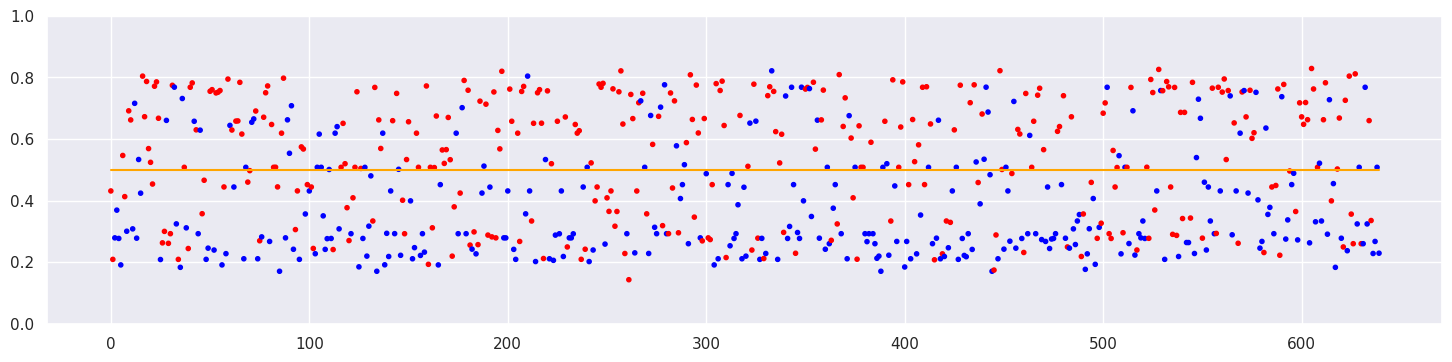

In [48]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

## Confusion matrix

Accuracy: 0.6890625
Precision: [0.65428571 0.73103448]
Recall: 0.6366366366366366
F1 score: 0.680578
ROC AUC: 0.691282


(0.6890625,
 array([0.65428571, 0.73103448]),
 0.6366366366366366,
 0.680577849117175,
 0.6912824876994258)

<Figure size 640x480 with 0 Axes>

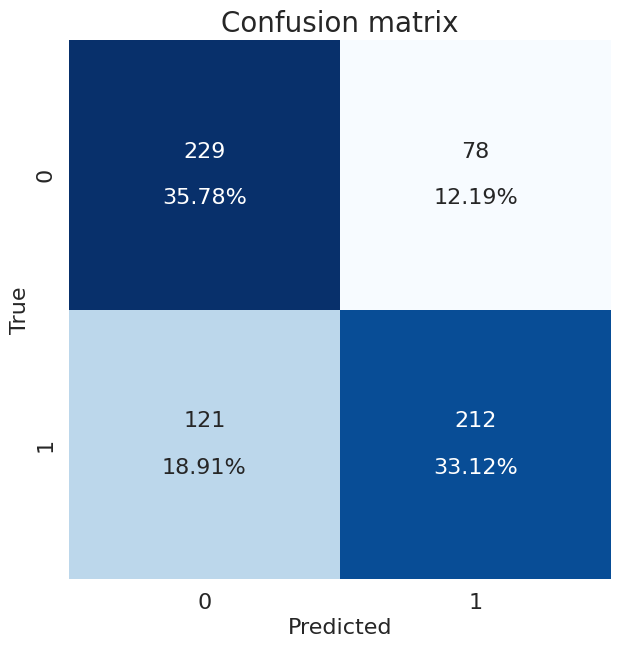

In [49]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

Accuracy: 0.6890625

Precision: [0.65428571 0.73103448]

Recall: 0.6366366366366366

F1 score: 0.680578

ROC AUC: 0.691282

## SHAP (SHapley Additive exPlanations) 

In [50]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

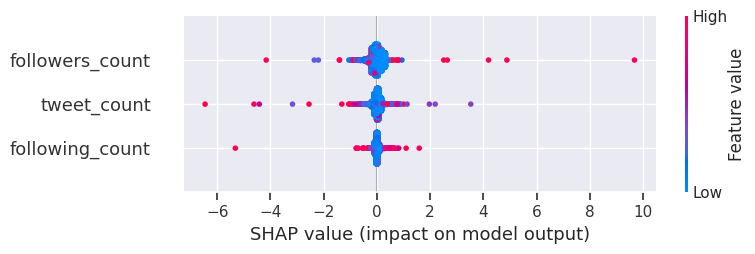

In [51]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

### Model 1.2 (with more epochs)

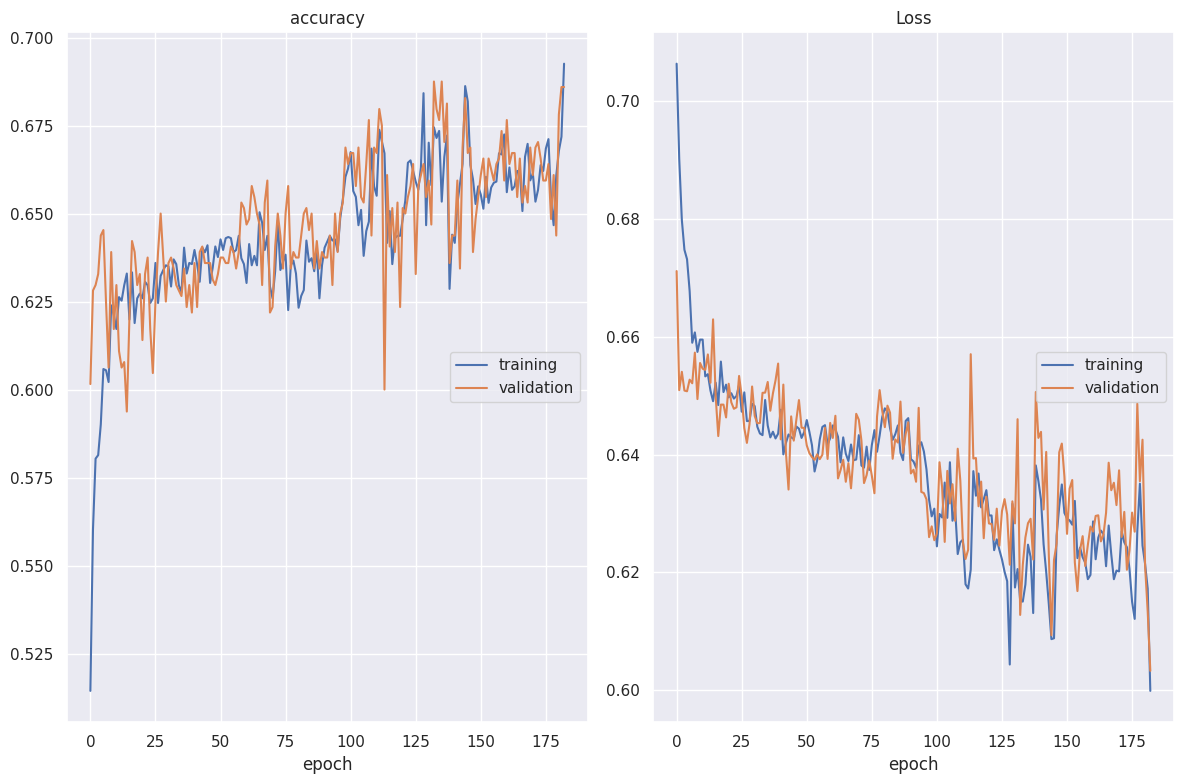

accuracy
	training         	 (min:    0.514, max:    0.693, cur:    0.693)
	validation       	 (min:    0.594, max:    0.688, cur:    0.686)
Loss
	training         	 (min:    0.600, max:    0.706, cur:    0.600)
	validation       	 (min:    0.603, max:    0.671, cur:    0.603)

Epoch 183: val_accuracy did not improve from 0.68750
60/60 [==============================] - 1s 14ms/step - loss: 0.5999 - accuracy: 0.6926 - val_loss: 0.6033 - val_accuracy: 0.6859


In [79]:
model_name2 = 'model_users_only_1000_1_v3'
shape = (train_X.shape[1],)
model2 = create_model_1(shape=shape)
model2 = train_model(model=model2, 
                     model_name=model_name2, 
                     train_X=train_X, 
                     train_Y=train_Y, 
                     val_X=val_X, 
                     val_Y=val_Y, 
                     batch_size=50, 
                     epochs=400)

#### Predict

In [80]:
out_Y_org2 = model.predict(test_X, verbose=0)
out_Y2 = [0 if x < 0.5 else 1 for x in out_Y_org2]

#### Results

(0.0, 1.0)

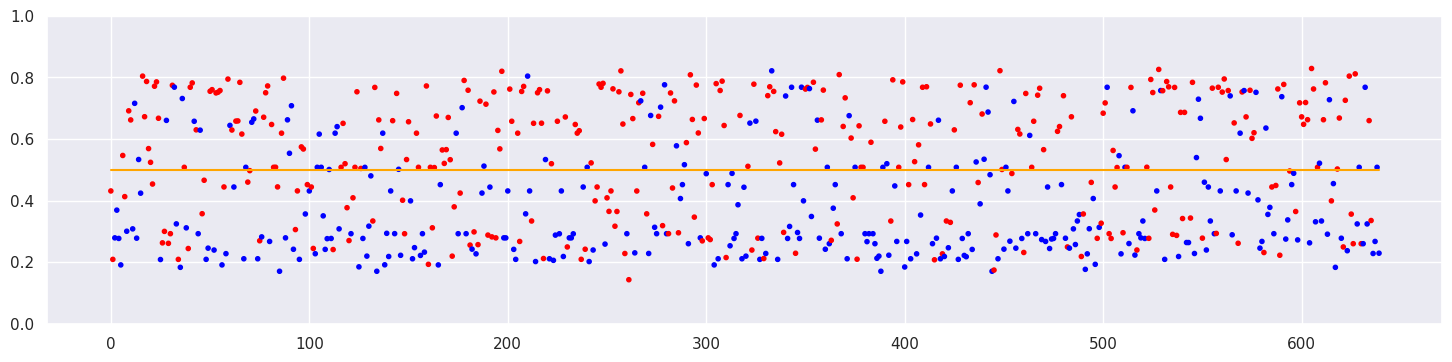

In [81]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org2, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.6890625
Precision: [0.65428571 0.73103448]
Recall: 0.6366366366366366
F1 score: 0.680578
ROC AUC: 0.691282


(0.6890625,
 array([0.65428571, 0.73103448]),
 0.6366366366366366,
 0.680577849117175,
 0.6912824876994258)

<Figure size 640x480 with 0 Axes>

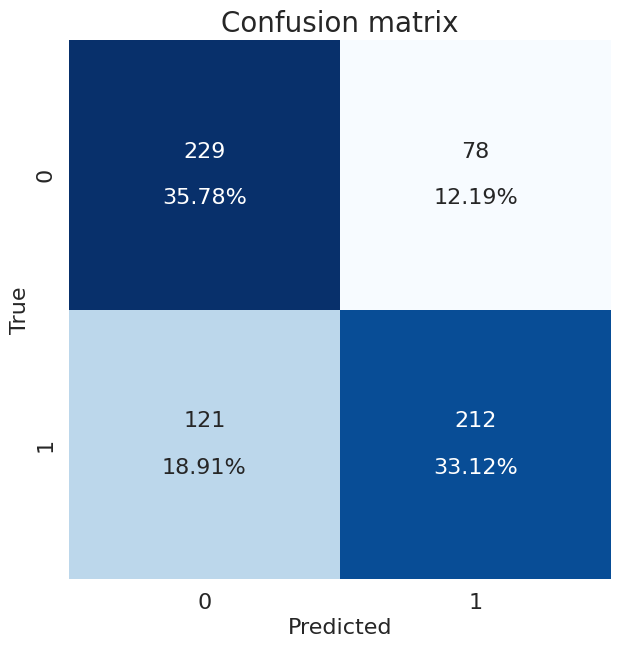

In [82]:
create_confusion_matrix(test_Y, out_Y2)
get_model_metrics(test_Y, out_Y2)

Accuracy: 0.6921875

Precision: [0.65449438 0.73943662]

Recall: 0.6306306306306306

F1 score: 0.680713

ROC AUC: 0.694794